<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/TSPmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 日本語フォントをダウンロードする。１度だけ実行
!apt-get -y install fonts-ipafont-gothic
# キャッシュを削除する。
!rm /root/.cache/matplotlib/fontlist-v300.json
# ランタイムを再起動する。

In [0]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/gdrive')

In [0]:
%%bash
# pip uninstall -y pyconcorde
# 巡回セールスマン問題の最適解を求めるためのライブラリ　導入
cd /tmp
git clone https://github.com/jvkersch/pyconcorde
cd pyconcorde
pip install .
cd /content

In [6]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
import seaborn as sns
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, Conv2DTranspose,Concatenate
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.layers import add, concatenate
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, CSVLogger
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model

import pickle


Using TensorFlow backend.


In [0]:
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path

XSIZE = 48
YSIZE = 48
MSIZE = 1 # 周辺にとるマージン 

# 巡回する点を生成する関数
def genTSP(pnum = 3, xsize=XSIZE,ysize=YSIZE, msize = MSIZE):
    
    # 訪問地点を指定数　（pnum）重複なく生成　ただし周辺は避ける
    posnumA,  posA = [], []
    while len(posnumA)<pnum:
        a = np.random.randint(0,(xsize-2*msize)*(ysize-2*msize))
        if a not in posnumA:
            posnumA.append(a)
            y = a//(xsize-2*msize)+msize
            x = a%(xsize-2*msize)+msize
            posA.append([x,y])
 
    #  画像の生成  
    tspimg = np.zeros((ysize,xsize),np.uint8) # 問題となる画像　　

    # 選ばれた点を描く
    for [x,y] in posA:
        tspimg[y,x] = 255
        # timg = tspimg[y-1:y+2,x-1:x+2]  # 点が隣接していて重なる場合、明るい方の色で描くことにする。
        # tspimg[y-1:y+2,x-1:x+2] = np.bitwise_or(timg, np.array([[200,255,200],[255,255,255],[200,255,200]]))
        
    return np.array(posA),tspimg

Text(0.5, 1.0, '巡回地点マップ')

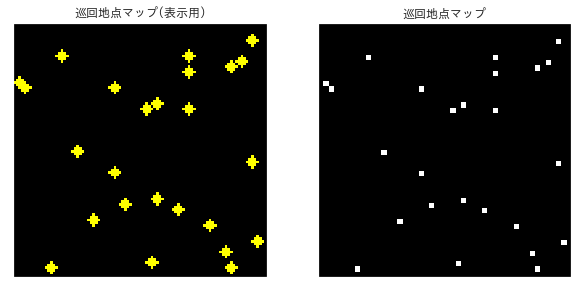

In [8]:
# 動作確認
refimg = np.zeros((2*YSIZE,2*XSIZE,3),np.uint8) # 表示拡大画像
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# jp_font = {'fontname':'IPAGothic'}
sns.set(font='IPAGothic')
posA,tspimg = genTSP(25)
for [x,y] in posA:
    refimg = cv2.circle(refimg,(2*x,2*y),2,(0,255,255),-1)  # 表示用の方は少し誇張して描く
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(refimg[:,:,::-1])
plt.title("{}".format("巡回地点マップ(表示用)"))
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(tspimg)
plt.gray()
plt.title("{}".format("巡回地点マップ"))

# TSPの学習用データの生成（concorde法）
- https://github.com/jvkersch/pyconcorde のプログラムを使わせていただく

# Concorde TSP Solver の動作確認

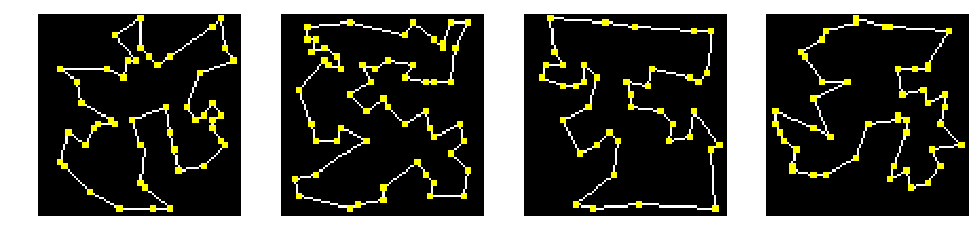

In [9]:
plt.figure(figsize=(12, 6), dpi=100)
for i in range(4):
    refimg = np.zeros((2*YSIZE,2*XSIZE,3),np.uint8) # 表示拡大画像
    plt.subplot(1, 4, i+1)
    poss, img = genTSP(pnum=np.random.randint(20,100),xsize=XSIZE,ysize=YSIZE,msize=MSIZE)
    xs = [x for [x,y] in poss]
    ys = [y for [x,y] in poss]
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    ps = solution.tour
    cv2.line(refimg,(2*xs[ps[0]],2*ys[ps[0]]),(2*xs[ps[-1]],2*ys[ps[-1]]),(255,255,255),1)
    p0 = ps[0]
    for p1 in ps[1:]:
      cv2.line(refimg,(2*xs[p0],2*ys[p0]),(2*xs[p1],2*ys[p1]),(255,255,255),1)
      cv2.rectangle(refimg,(2*xs[p0]-1,2*ys[p0]-1),(2*xs[p0]+1,2*ys[p0]+1),(0,255,255),-1)
      p0 = p1
    plt.imshow(refimg[:,:,::-1])
    plt.axis('off')

# TSPの問題画像と解画像の生成

In [0]:
XSIZE,YSIZE,MSIZE = 48,48,1
minP = 5
maxP = 20

# TSPの問題と答えの生成(1セット) 
def genTSPSample(minP, maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE):
    plist, img = genTSP(pnum=np.random.randint(minP,maxP),xsize=XSIZE,ysize=YSIZE,msize=MSIZE)

    # TSP の最適解を求める
    xs = [x for [x,y] in plist]  # X座標のみのリスト
    ys = [y for [x,y] in plist]  # Y座標のみのリスト
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    tspsol = solution.tour # インデックス表現した解
    
    # 解画像を生成する
    simg = np.zeros_like(img)
    cv2.line(simg,(xs[ps[0]],ys[ps[0]]),(xs[tspsol[-1]],ys[tspsol[-1]]),255,1)
    p0 = tspsol[0]
    for p1 in tspsol[1:]:
        simg = cv2.line(simg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),255,1)
        p0 = p1

    return (plist, tspsol, img, simg)

# TSPの解と正解のペアを指定数生成する関数
minP = 5  # 地点数の最小値
maxP = 25 # 地点数の最大値

def genTSPSamples(num = 100, minP = minP, maxP = maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE):
    data = []  
    for i in range(num):
        data.append(genTSPSample(minP=minP, maxP=maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE))
    return data


# 訓練例の生成
せっかく作ったデータなので，google drive にも保存しておくことにする

In [11]:
%%time

SETNUM = 2

for i in range(SETNUM):
    pset = genTSPSamples(10000)
    f = open('/gdrive/My Drive/minitest1000_'+str(i),'wb')
    pickle.dump(pset,f)
    f.close

CPU times: user 2min 4s, sys: 30.6 s, total: 2min 35s
Wall time: 3min 28s


## google drive からのデータの読み込み 

In [12]:
%%time
f1 = open('/gdrive/My Drive/minitest1000_0','rb')
f2 = open('/gdrive/My Drive/minitest1000_1','rb')
train = pickle.load(f1)
testdata = pickle.load(f2)
f1.close
f2.close

CPU times: user 247 ms, sys: 43.3 ms, total: 291 ms
Wall time: 320 ms


## 読み込みデータの確認

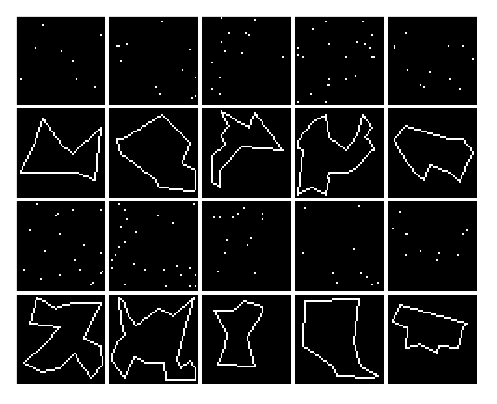

In [13]:
plt.figure(figsize=(6, 12), dpi=100)
simg = np.ones((200,250),np.uint8)*255
for j in range(5):
    i = 0
    simg[100*i:100*i+48,50*j:50*j+48] = cv2.resize(train[5*i+j][2],(48,48))
    simg[100*i+50:100*i+98,50*j:50*j+48] = cv2.resize(train[5*i+j][3],(48,48))
    i = 1
    simg[100*i:100*i+48,50*j:50*j+48] = cv2.resize(testdata[5*i+j][2],(48,48))
    simg[100*i+50:100*i+98,50*j:50*j+48] = cv2.resize(testdata[5*i+j][3],(48,48))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.imshow(simg)

# データの水増し
左右反転，上下反転，90度回転の組み合わせで
一般画像認識であればこのような水増しは意味があるが，TSPの場合好きなだけ問題は作れるので，
このような水増しは解画像生成の時間節約の意味しかない

In [0]:
# 左右反転，上下反転，90度回転の組み合わせで１つの問題から８つの問題を生成する．
def dataInflation(atsp):
    (_plist, _tspsol, x, y) = atsp
    X,Y = [x],[y] # 種となる問題(img)と解画像（simg）
    # 上下反転
    X.append(np.flip(x,axis=0))
    Y.append(np.flip(y,axis=0))
    # 左右反転
    X.append(np.flip(x,axis=1))
    Y.append(np.flip(y,axis=1))
    # 上下反転＋左右反転（180度回転）
    X.append(np.flip(x,axis=None))
    Y.append(np.flip(y,axis=None))
    # 反時計回りに90度正方向回転
    X.append(np.rot90(x,k=1))
    Y.append(np.rot90(y,k=1))
    # 上のデータ（X[-1]）を上下反転
    X.append(np.flip(X[-1],axis=0))
    Y.append(np.flip(Y[-1],axis=0))
    # 時計回りに90度
    X.append(np.rot90(x,k=-1))
    Y.append(np.rot90(y,k=-1))    
    # 上のデータ（X[-1]）を上下反転
    X.append(np.flip(X[-1],axis=0))
    Y.append(np.flip(Y[-1],axis=0))
    return X,Y

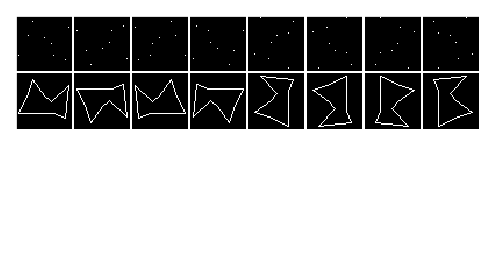

In [15]:
# 動作確認 
X,Y = dataInflation(train[0]) 
plt.figure(figsize=(6, 12), dpi=100)
simg = np.ones((200,400),np.uint8)*255
for j in range(8):
    simg[0:48,50*j:50*j+48] = cv2.resize(X[j],(48,48))
    simg[50:98,50*j:50*j+48] = cv2.resize(Y[j],(48,48))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.imshow(simg)

問題すべてを8倍に水増しし，問題画像のリストXと解画像のリストYを得る

In [0]:
X,Y = [],[]
for atsp in train:
    x, y = dataInflation(atsp)
    X = X + x
    Y = Y + y

# CNNモデル

In [17]:
K3 = (3,3)
K5 = (5,5)
K6 = (6,6)
K7 = (7,7)
K8 = (8,8)
slope_co = 0.0 # 0ならReLU

# Model

input = Input(shape=(48,48,1))
# Layer 1  (48,48,1) -> strides1 -> (48,48,64)
conv1 = Conv2D(64, K5, padding='same', strides=1)(input)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (48,48,64) ->MaxPooling2D -> (24,24,64)
pool1 = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(conv1)
drop1 = Dropout(rate = 0.25)(pool1)

# Layer 3  (24,24,64) -> strides1 -> (24,24,64)
conv2 = Conv2D(64, K7, strides=1, padding='same')(drop1)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 4  (24,24,64) -> MaxPooling2D -> (12,12,64)
pool2 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv2)
drop2 = Dropout(rate = 0.25)(pool2)

# Layer 5  (12,12,64) -> strides1 -> (12,12,64)
conv3 = Conv2D(64, K5, strides=1, padding='same')(drop2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 6  (12,12,64) -> MaxPooling2D -> (6,6,64)
pool3 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv3)
drop3 = Dropout(rate = 0.25)(pool3)

# Layer 7  (6,6,64) -> strides1 -> (6,6,64+64)
conv4 = Conv2D(64, K3, strides=1, padding='same')(drop3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=slope_co)(conv4)
conv4 = concatenate([drop3,conv4])

# Layer 8 UP (6,6,128) -> strides2 -> (12,12,64)
conv5 = Conv2DTranspose(64, K5, strides=2, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 9  (12,12,64) -> strides1 -> (12,12,32+64)
conv6 = Conv2D(32, K5, strides=1, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)
conv6 = concatenate([drop2,conv6])

# Layer 10 UP (12,12,96) -> strides2 -> (24,24,64)
conv7 = Conv2DTranspose(64, K7, strides=2, padding='same')(conv6)
conv7 = LeakyReLU(alpha=slope_co)(conv7)
drop4 = Dropout(rate = 0.25)(conv7)


# Layer 11  (24,24,64) -> strides1 -> (24,24,64)
conv8 = Conv2D(64, K7, strides=1, padding='same')(drop4)
conv8 = LeakyReLU(alpha=slope_co)(conv8)
conv8 = concatenate([drop1,conv8])
                    
# Layer 14 UP (24,24,64) -> strides2 -> (48,48,32)
conv9 = Conv2DTranspose(32, K5,strides=2, padding='same')(conv8)
conv9 = LeakyReLU(alpha=slope_co)(conv9)

# Layer 15  (48,48,32) -> strides1 -> (48,48,32)
conv10 = Conv2D(32, K5, strides=1, padding='same')(conv9)
conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 18  (48,48,32) -> strides1 -> (48,48,1)
output = Conv2D(1, K5, strides=1, padding='same')(conv10)
#output = Activation('relu')(output)

orig_model = Model(input,output)

orig_model.summary()

W0623 13:18:33.864687 139928848824192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 13:18:33.901056 139928848824192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 13:18:33.910738 139928848824192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 13:18:33.954464 139928848824192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0623 13:18:33.955310 1399288488

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 48, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 48, 48, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

/content


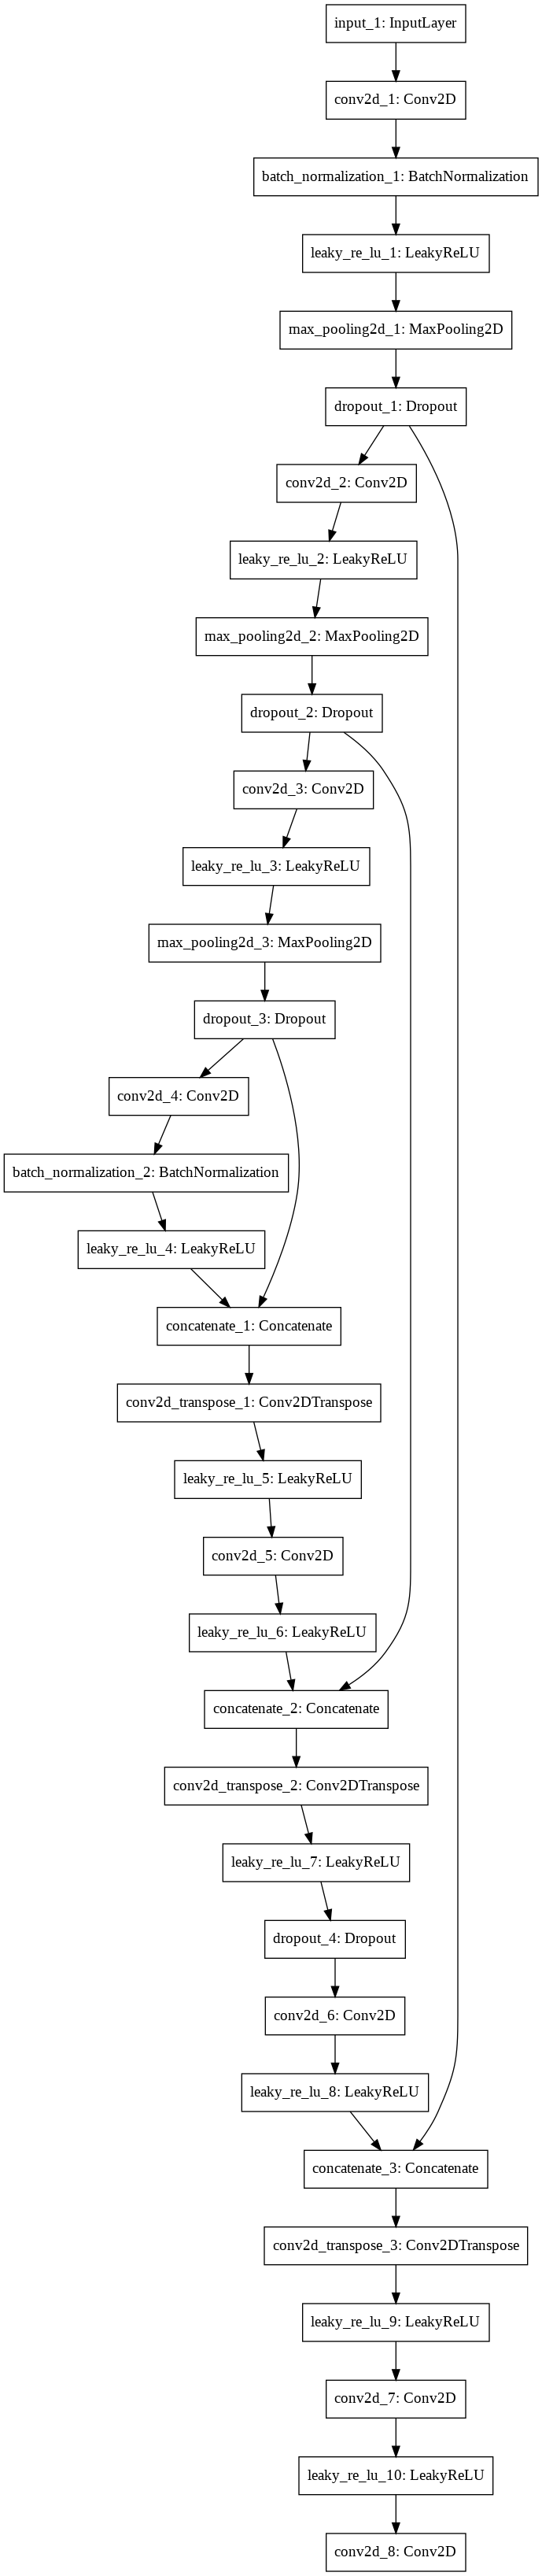

In [18]:
from IPython.display import Image, display_png
%cd /content
#学習モデル図の作成
plot_model(orig_model, to_file='orig_model.png')
display_png(Image('orig_model.png'))

In [19]:
orig_model.compile(loss= 'mean_squared_error',#  'binary_crossentropy',#   # 'binary_crossentropy', # ,
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

W0623 13:18:37.945602 139928848824192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [20]:
dsize = len(X)
batch_size = 32
epochs = 100

X1 = np.array(X).reshape(dsize,48,48,1).astype('float32')
X1 = X1/255

Y1 = np.array(Y).reshape(dsize,48,48,1).astype('float32')              
Y1 = Y1/255

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = orig_model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.5, # 50 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                  callbacks=[es, csv_logger])


Train on 40000 samples, validate on 40000 samples
Epoch 1/100
40000/40000 [==============================] - 47s 1ms/step - loss: 0.0372 - acc: 0.9539 - val_loss: 0.0287 - val_acc: 0.9627
Epoch 2/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.0272 - acc: 0.9648 - val_loss: 0.0229 - val_acc: 0.9705
Epoch 3/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.0229 - acc: 0.9702 - val_loss: 0.0206 - val_acc: 0.9735
Epoch 4/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.0206 - acc: 0.9732 - val_loss: 0.0182 - val_acc: 0.9767
Epoch 5/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.0192 - acc: 0.9751 - val_loss: 0.0169 - val_acc: 0.9785
Epoch 6/100
40000/40000 [==============================] - 43s 1ms/step - loss: 0.0182 - acc: 0.9763 - val_loss: 0.0167 - val_acc: 0.9786
Epoch 7/100
40000/40000 [==============================] - 44s 1ms/step - loss: 0.0176 - acc: 0.9772 - val_loss: 0.0157 - 

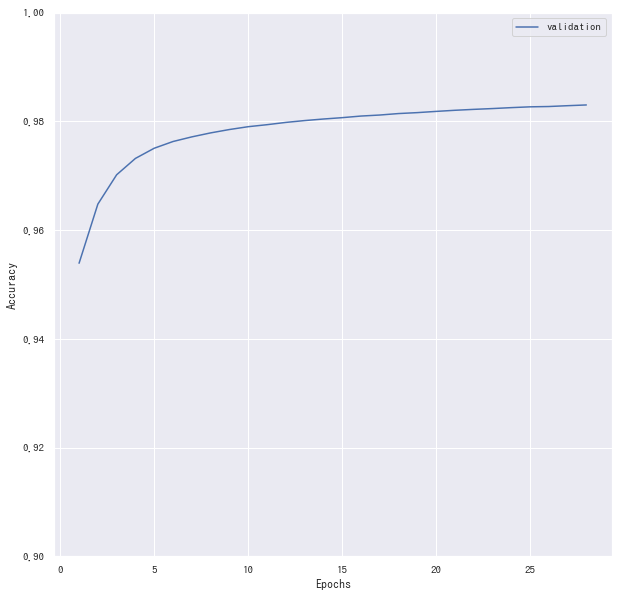

In [21]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

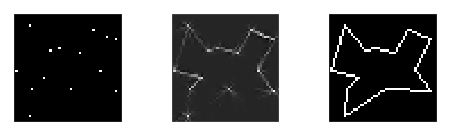

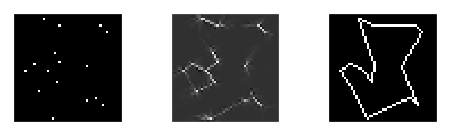

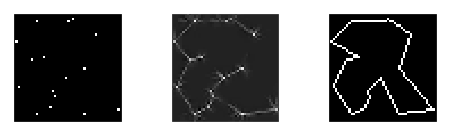

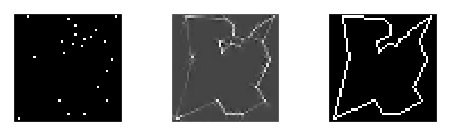

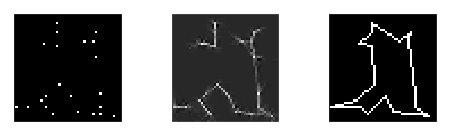

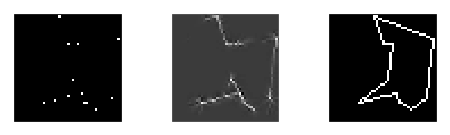

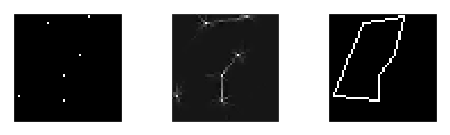

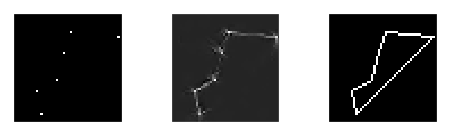

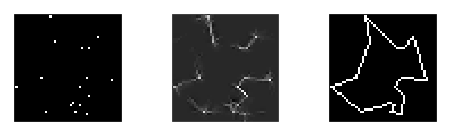

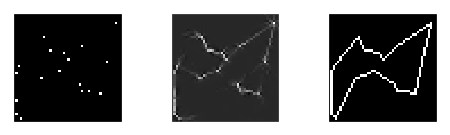

In [22]:
def test(X,Y):
    output = orig_model.predict(X.reshape(1,48,48,1))
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(48,48)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-X.reshape(48,48),cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    output = (output-output.min())/(output.max()-output.min())
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-Y.reshape(48,48),cmap=plt.cm.binary)
    
for i in range(10):
    (_,_,img,simg) = train[i+249]
    test(img,simg)

In [23]:
K3 = (3,3)

K5 = (5,5)

K7 = (7,7)

K8 = (8,8)
slope_co = 0.0 # 0ならReLU

# Model

input = Input(shape=(48,48,1))
# Layer 1  (48,48,1) -> strides1 -> (48,48,64)
conv1 = Conv2D(64, K3, padding='same', strides=1)(input)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (48,48,64) ->MaxPooling2D -> (24,24,64)
pool1 = MaxPooling2D(pool_size=(2,2), strides=(2, 2))(conv1)
drop1 = Dropout(rate = 0.25)(pool1)

# Layer 3  (24,24,64) -> strides1 -> (24,24,64)
conv2 = Conv2D(64, K5, strides=1, padding='same')(drop1)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 4  (24,24,64) -> MaxPooling2D -> (12,12,64)
pool2 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv2)
drop2 = Dropout(rate = 0.25)(pool2)

# Layer 5  (12,12,64) -> strides1 -> (12,12,64)
conv3 = Conv2D(64, K3, strides=1, padding='same')(drop2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 6  (12,12,64) -> MaxPooling2D -> (6,6,64)
pool3 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv3)
drop3 = Dropout(rate = 0.25)(pool3)

# Layer 7  (6,6,64) -> strides1 -> (6,6,64+64)
conv4 = Conv2D(64, K3, strides=1, padding='same')(drop3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=slope_co)(conv4)
conv4 = concatenate([drop3,conv4])

# Layer 8 UP (6,6,128) -> strides2 -> (12,12,64)
conv5 = Conv2DTranspose(64, K3, strides=2, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 9  (12,12,64) -> strides1 -> (12,12,32+64)
conv6 = Conv2D(32, K3, strides=1, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)
conv6 = concatenate([drop2,conv6])

# Layer 10 UP (12,12,96) -> strides2 -> (24,24,64)
conv7 = Conv2DTranspose(64, K5, strides=2, padding='same')(conv6)
conv7 = LeakyReLU(alpha=slope_co)(conv7)
drop4 = Dropout(rate = 0.25)(conv7)


# Layer 11  (24,24,64) -> strides1 -> (24,24,64)
conv8 = Conv2D(64, K7, strides=1, padding='same')(drop4)
conv8 = LeakyReLU(alpha=slope_co)(conv8)
conv8 = concatenate([drop1,conv8])
                    
# Layer 14 UP (24,24,64) -> strides2 -> (48,48,32)
conv9 = Conv2DTranspose(32, K7,strides=2, padding='same')(conv8)
conv9 = LeakyReLU(alpha=slope_co)(conv9)

# Layer 15  (48,48,32) -> strides1 -> (48,48,32)
conv10 = Conv2D(32, K5, strides=1, padding='same')(conv9)
conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 18  (48,48,32) -> strides1 -> (48,48,1)
output = Conv2D(1, K5, strides=1, padding='same')(conv10)
#output = Activation('relu')(output)

orig_model = Model(input,output)

orig_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 48, 48, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 48, 48, 64)   256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 48, 48, 64)   0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
max_poolin

In [24]:
orig_model.compile(loss= 'binary_crossentropy',#   # 'binary_crossentropy', # ,'mean_squared_error',
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

W0623 13:39:08.326822 139928848824192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
dsize = len(X)
batch_size = 32
epochs = 100

X1 = np.array(X).reshape(dsize,48,48,1).astype('float32')
X1 = X1/255

Y1 = np.array(Y).reshape(dsize,48,48,1).astype('float32')              
Y1 = Y1/255

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = orig_model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.75, # 50 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                  callbacks=[es, csv_logger])


Train on 20000 samples, validate on 60000 samples
Epoch 1/100
20000/20000 [==============================] - 37s 2ms/step - loss: 0.1903 - acc: 0.9441 - val_loss: 0.1682 - val_acc: 0.9464
Epoch 2/100
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1728 - acc: 0.9441 - val_loss: 0.1982 - val_acc: 0.9408
Epoch 3/100
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1694 - acc: 0.9429 - val_loss: 0.1519 - val_acc: 0.9403
Epoch 4/100
20000/20000 [==============================] - 34s 2ms/step - loss: 0.1525 - acc: 0.8998 - val_loss: 0.1463 - val_acc: 0.8136
Epoch 5/100
20000/20000 [==============================] - 35s 2ms/step - loss: 0.1491 - acc: 0.8470 - val_loss: 0.1509 - val_acc: 0.8675
Epoch 6/100
20000/20000 [==============================] - 36s 2ms/step - loss: 0.1408 - acc: 0.8108 - val_loss: 0.1258 - val_acc: 0.7558
Epoch 7/100
20000/20000 [==============================] - 35s 2ms/step - loss: 0.1336 - acc: 0.7500 - val_loss: 0.1472 - 

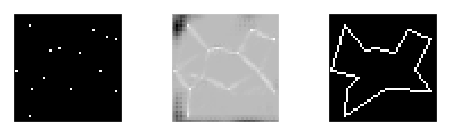

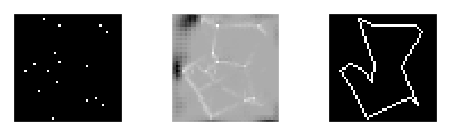

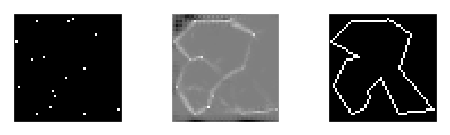

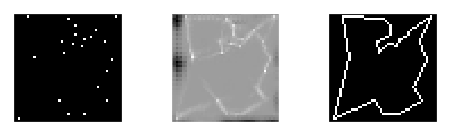

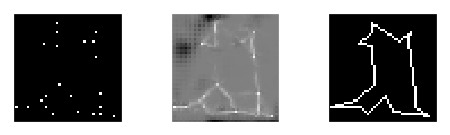

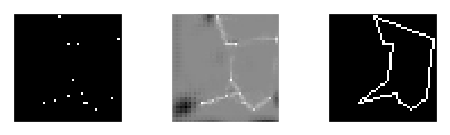

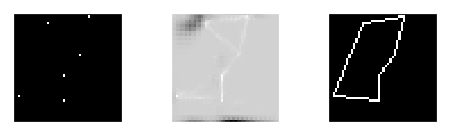

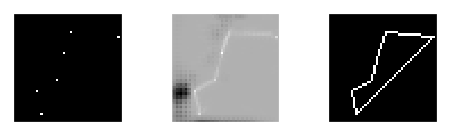

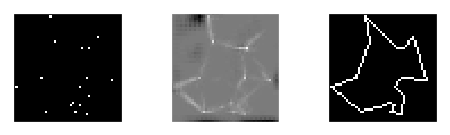

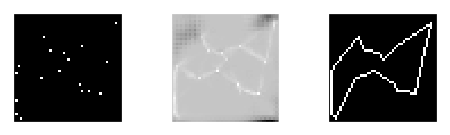

In [26]:
def test(X,Y):
    output = orig_model.predict(X.reshape(1,48,48,1))
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(48,48)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-X.reshape(48,48),cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    output = (output-output.min())/(output.max()-output.min())
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-Y.reshape(48,48),cmap=plt.cm.binary)
    
for i in range(10):
    (_,_,img,simg) = train[i+249]
    test(img,simg)